In [1]:
import numpy as np
from matplotlib import pyplot as plt
from math import pi
import math
plt.style.use('seaborn-poster')

In [56]:
''' 
Setting initial values and constants 
'''
T = 10
N = 6

'''
Setting log scale for all future logplots.
'''

logs_one = np.logspace(0, N, num=30)
indexes_to_print = [int(index) for index in logs_one]
indexes_to_print[-1] -= 1



#### Section 1: Buffon's needle simulation

In [4]:
def get_random_position (size):
    '''
    Returns the x,y for the position of the middle of the needle
    draws a position from a uniform distribution
    '''
    
    x_position = np.random.uniform(0, size)
    y_position = np.random.uniform(0, size)

    return (x_position, y_position)


def get_random_angle():
    '''
    To avoid using Pi, I calculated the angles using the radian circle on a cartesian system.
    The values (x,y) are sampled from a uniform distribution in the positive radian circle (hypotenuse <=1)
    This samples an angle between 0-180 represented in its radian value
    '''
    hyp = 1.1

    while hyp > 1:
        dx = np.random.uniform(-1,1)
        dy = np.random.uniform(0,1)
        hyp = math.sqrt (dx ** 2 + dy ** 2)
    
    if hyp <=1:
        # Return atan(y / x) in rad
        return math.atan2(dy,dx)



def check_if_cross_line (edge_position1, edge_position2, length, line_gap):
    '''
    Examines if the needle touches the line. 
    2 options: (1) edge1 > edge2 (2)edge1 < edge2
    The condition checks both cases and returns true if either holds
    
    '''
    for line in range(0, length+1, line_gap):

        if (line >= edge_position1 and line <= edge_position2) or (line >= edge_position2 and line <= edge_position1):
            
            return True


def drop_needles(size, needle_length, gap_between_lines): 
    '''
    This function drops the needles on the board using the random values sampled
    since the lines are vertical, the relevant position is the value of the x-axis
    The random position is the position of the middle of the needle
    The edge position calculated using the random angle 
    The function returns true if the needle crosses the lines.
    '''
    #drop_needles
    needle_position = get_random_position(size)

    needle_x_position = needle_position[0]

    angle = get_random_angle()
 
    needle_edge_position_x_1 = (needle_x_position + ((needle_length/2.0) * np.cos(angle)))

    needle_edge_position_x_2 = (needle_x_position - ((needle_length/2.0) * np.cos(angle)))

    return check_if_cross_line(needle_edge_position_x_2, needle_edge_position_x_1, size, gap_between_lines) 
   

def calculate_err (pi_approximations):
    '''
    Using confidence intervals to calculate the error
    Calculating the bounds as = $\frac{2}{\frac{2}{\pi} +- 1.96 \sigma}$ 
    Calculating the interval as the difference of the bounds from real value of Pi (population mean)
    
    '''
    err_array = []
    
    for throws, pi_approx in enumerate(pi_approximations):
                
         
        
        if throws == 0 or pi_approx ==0:
            err_array.append ([0,0])
            
        else:
            sigma = math.sqrt((2.0/pi) * (1 - (2.0/pi)) / throws)
            pi_ci = sigma * 1.96

            lower_ci = 2.0/ ( 2/pi_approx + pi_ci )
            upper_ci = 2.0/ ( 2/pi_approx - pi_ci )

            err_array.append([pi_approx-lower_ci, upper_ci-pi_approx])

    return {'err':err_array}

def simulation(needle_drops, needle_length=5, gap_between_lines=6):
    '''
    This function runs one simulation.
    The function calculates a running approximation and confidence intervals for each throw 
    Using P/N = (2/pi) * (l/d) -> pi = 2 * (l/d) * (N/P) to approximate Pi
    '''
    
    size = gap_between_lines * 3

    hits = 0.0
    
    pi_aprox_per_needle = []
    err = []
    
    for throws in range(needle_drops):

        if drop_needles(size, needle_length, gap_between_lines): 
            hits += 1

        if hits != 0 and throws != 0:
            
            # pi approximation
            pi_approx = 2 * (float(needle_length)/gap_between_lines) * (throws/hits) 
            pi_aprox_per_needle.append(pi_approx)
               
        else:
            pi_aprox_per_needle.append(0)        
        
  
    return pi_aprox_per_needle


def tests (num_of_tests, throws):
    '''
    Runs num_of_tests simulations and returns the relevant values :
    for one simulation: the approximation in the different levels of N, and the confidence intervals
    for multiple simulations: the mean approximation, the raw approximation, and the standard error
    
    
    '''
    

    if num_of_tests == 1:
        
        pi_approx = simulation(throws)
        error_results = calculate_err(pi_approx)
        
        pi_ci_array = error_results['err']

        
        return {'avg': [], 'raw': pi_approx, 'ci': pi_ci_array, 'SE':[]}


    else:
        
        pi_approx_array = []
        
        for _ in range(num_of_tests):
            
            pi_approx = simulation(throws)
            error_results = calculate_err(pi_approx)
            
            pi_approx_array.append(pi_approx)
            
            
        np_pi_approx = np.array(pi_approx_array)


        return {'avg': np_pi_approx.mean(axis = 0), 'raw': pi_approx_array, 'ci': [], 'SE': np.std(pi_approx_array, axis =0) }

    
    

#### Section 2:

In [37]:
'''
Runs 10 simulations for levels between 0 to 10^6

'''

estimation_mean = tests(T ,10**N)



In [59]:
se_mean = estimation_mean['SE']
raw_mean = estimation_mean['raw']

values_to_print_mean = [se_mean[index] for index in indexes_to_print]


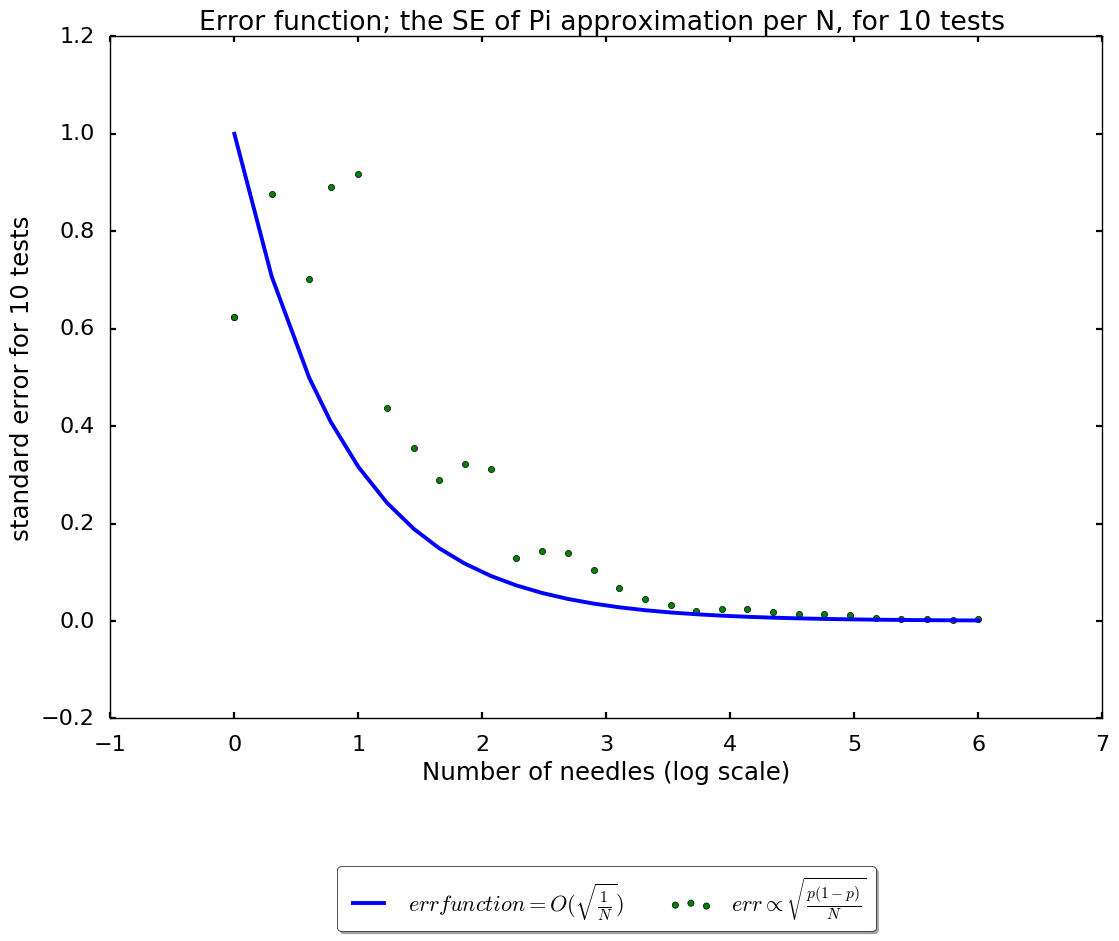

In [62]:
''' 
Plots the error function using CI 
the formula to calculate proportional CI is \sigma = (p(1-p)/N)^.5, where sigma is the standard deviation and p is the probability
Hence, the error function is O(1/N^.5)
'''

plt.scatter([np.log10(i) for i in indexes_to_print], values_to_print_mean, c='green', label =r'$err  \propto \sqrt{\frac {p(1-p)}{N}}$ ')
plt.xlabel ('Number of needles (log scale)')
plt.ylabel ('standard error for {} tests'.format(T_mean))
plt.plot([np.log10(i) for i in indexes_to_print], [1/i**.5 for i in indexes_to_print], c='b', label = r'$err function = O(\sqrt{\frac {1}{N}})$')
plt.title ("Error function; the SE of Pi approximation per N, for {} tests ".format(T))

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)    
plt.show()


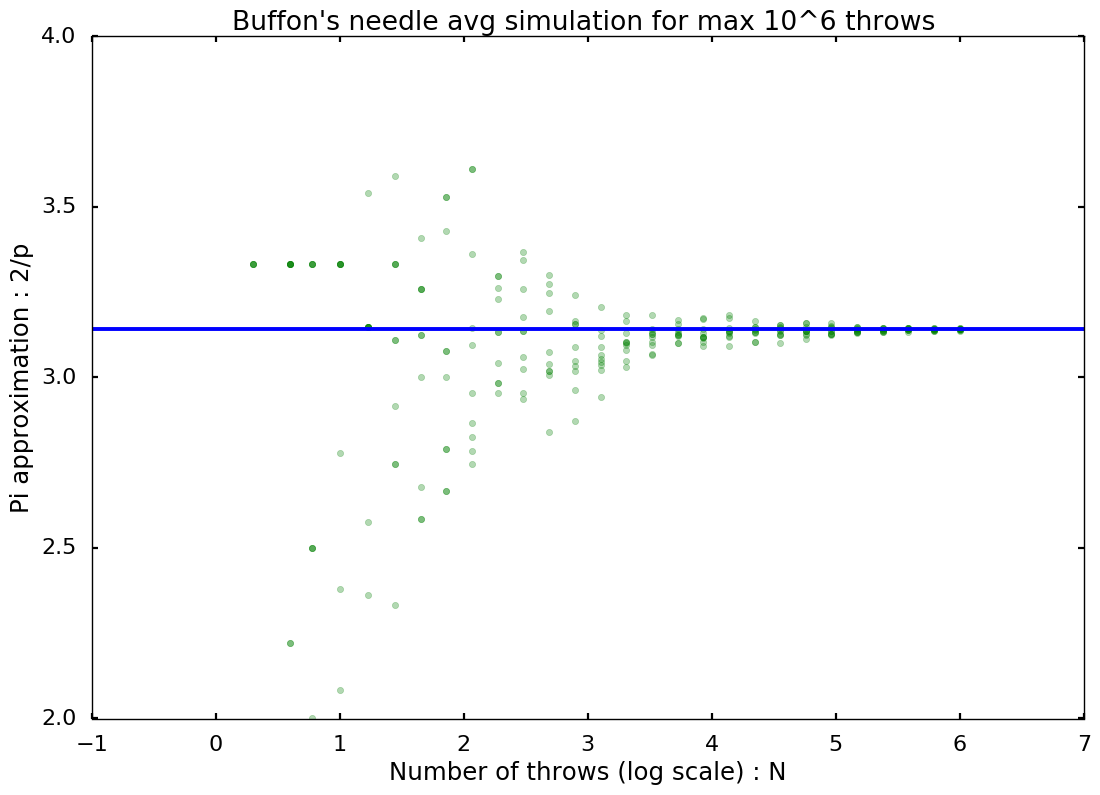

In [61]:
''' 
Plots the results of T simulations
'''

for i in range(T):

    row = raw_mean[i]
    values_to_print_in_a_row = [row[index] for index in indexes_to_print]

    plt.scatter ([np.log10(i) for i in indexes_to_print], values_to_print_in_a_row, color='g', alpha= '0.3')


plt.axhline(y=math.pi, color='b', linestyle='-')
# plt.plot ([np.log10(i) for i in indexes_to_print], values_to_print, color='g')
plt.xlabel ('Number of throws (log scale) : N')
plt.ylabel ('Pi approximation : 2/p')
plt.title ("Buffon's needle avg simulation for max 10^{} throws ".format(N))
plt.ylim (2,4)
plt.show ()



#### Section 3: 

In [122]:
'''
Runs 1 simulations between 0 to 10^N
'''


estimation_per_one_simulation = tests(1 ,10 ** N)

raw_one = estimation_per_one_simulation['raw']
ci_one = estimation_per_one_simulation['ci']



In [123]:
'''
getting values and intervals for one simulation
'''
values_to_print_one = [raw_one[index] for index in indexes_to_print]
ci_to_print_one = np.transpose([ci_one[index] for index in indexes_to_print])




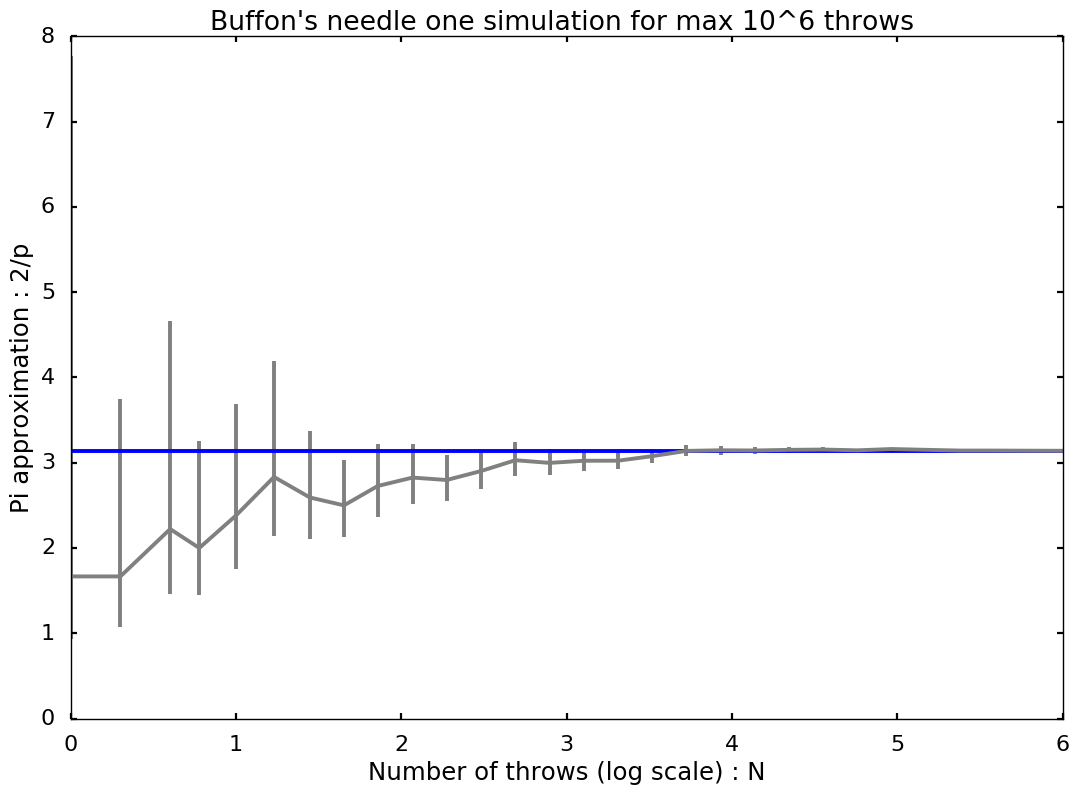

In [124]:
'''
Plots 1 simulation with err bars
'''

plt.axhline(y=math.pi, color='b', linestyle='-')
# plt.plot ([np.log10(i) for i in indexes_to_print], values_to_print, color='g')
plt.xlabel ('Number of throws (log scale) : N')
plt.ylabel ('Pi approximation : 2/p')
plt.title ("Buffon's needle one simulation for max 10^{} throws ".format(N))
plt.errorbar([np.log10(i) for i in indexes_to_print], values_to_print_one, yerr=ci_to_print_one, color ='grey')
plt.show ()

#### section 4:

(1) keep the code simple.

We can use Pi's "special" fractions to hit higher accuracy. Manipulating the formula to one of these fractions can result in greater accuracy. For example the convergent $ \frac{355}{113} $ provides an approximation of $\pi$ with an accuracy of 6 digits. Simulating the following initial values can, on average, create six decimal points accuracy. 

$ \frac{P}{3408} = \frac{2}{approx-pi} * \frac{5}{6} $ 
these numbers provides this aproximation : $ \frac{1808}{3408} ≈ \frac{2}{approx-pi} * \frac{5}{6} ≈ \frac{355}{113}$ 

(2) keep the estimate as accurate as possible for a given number of samples.

There are several ways to interpret this question. Following the mathematical proof of the model, a possible modification is to throw several needles is the same time. The larger some sides of the polygons get, the smaller the number of throws needed. Since the probability of a hit increasing with some sides. Using linearity we can transform this formula for a one-sided needle: $p = \frac{l}{d} * \frac{2}{\pi} $ to a $p_c = \frac{cl}{d} * \frac{2}{\pi} $  
Meaning, we can increase accuracy per throws by increasing the sides of the polygon thrown.

The math goes as far a traeting a circle as a polygon that requires simply one throw. A circle with a diameter d, is a polygon of a length $d\pi$ (the circumference of a circle), which is expected to touch the lines exactly 2 times (p=2). Using Buffon's formula to calculate $\pi$ results in: $ \frac{P}{N} = \frac{2}{approx-pi} * \frac{l}{d} -> \frac{2}{1} = \frac{2}{approx-pi} * \frac{2d \pi }{d} -> \frac{\pi}{approx-pi} = 1$  
In a single sample (one throw of a po;ygon in a shape of a circle) we can estimate $\pi$ 100% accuratly.


#### Section 5:

The amount of decimal accuracy is a direct function of how much error is reasonable for the application. For a linear use of Pi, The error is proportional to the difference between Pi and the approximation. Since each added digit reflects an order of magnitude, the error is on average improved by a factor of 10 with each digit. We can calculate the exact error using $\frac{\pi - pi-approximation}{pi-approximation}$.

Thinking of the biggest size there is: The size of the observable.
How many decimals NASA uses in its current measurements of the elements within the observable universe?  

The observable universe diameter is 8.8 * 10^26 m

Calculating its circumference using an approximation of Pi will result in the following error:
circumference = $ 2*\pi*r $ 

calculating the err given by x digits : 
$ \frac{\pi diameter -  \pi_39 diameter}{\pi_39 diameter}= -2.5 * 10*{-12}$.  
NASA likes bragging that this error is smaller than the size of one hydrogen atom. 

Estimating running time for accuracy for the Buffon's needle algorithm:

The variance is calculted using $\sigma  = \sqrt{\frac {p(1-p)}{N}}$  
    The error is to be calculated as : $\frac{2}{\frac{2}{\pi}+1.96 \sigma}$  
    Using it, calculating how many samples needed to get an x digits accuracy is as follows:
    Pi approximation with X digits after the decimal point accuracy within 95% confidence level can be calculated by calculating the variance that reflects an error in smaller parts of the approximation. Meaning, x digits accuracy, within 95 % confidence, is where the interval is smaller than $10^{-x}$. Using the sigma function, this example's solution lies in the combination of these 3 relations:  
      
    Combining:
    
1. $ \frac{P}{N} = \frac{2}{\pi} -> p = \frac{2}{\pi} $ 
2. $ \sigma  = \sqrt{\frac {p(1-p)}{N}}$
3. $ \pi - \frac{2}{\frac{2}{approx-pi} + 1.96 \sigma} <= 10^{-x} $
4. $ X = 10^{-x} $
    
    
    We can put together the formula (using either lower or upper bound):

$\pi - \frac{2}{\frac{2}{approx-pi} + 1.96 \sqrt{\frac {(\frac{2}{\pi})(1-(\frac{2}{\pi}))}{N}}} <= X $

    Solving for N :
    
$ \frac{-2}{\frac{2}{\pi} +1.96 \sqrt{\frac {(\frac{2}{\pi})(1-(\frac{2}{\pi}))}{N}}}= X-\pi $  

->

$ N= \frac{1.96^2 * \frac{2}{\pi}(1-\frac{2}{\pi})}{(\frac{2}{\pi -X} - \frac{2}{\pi})^2} $

    
    


In [110]:
'''
accuracy for x
'''
# n = ((1.96**2 )*(2/pi)*(1-2/pi))/(2/(pi-x)-2/pi)**2
n_needed = []

for digits in range (1,15):
    decimals = 10.0**(-digits)
    p = 2/pi
    n_needed.append(p*(1-p)/((((2/(pi - decimals))-(2/pi))/1.96)**2))
    
 

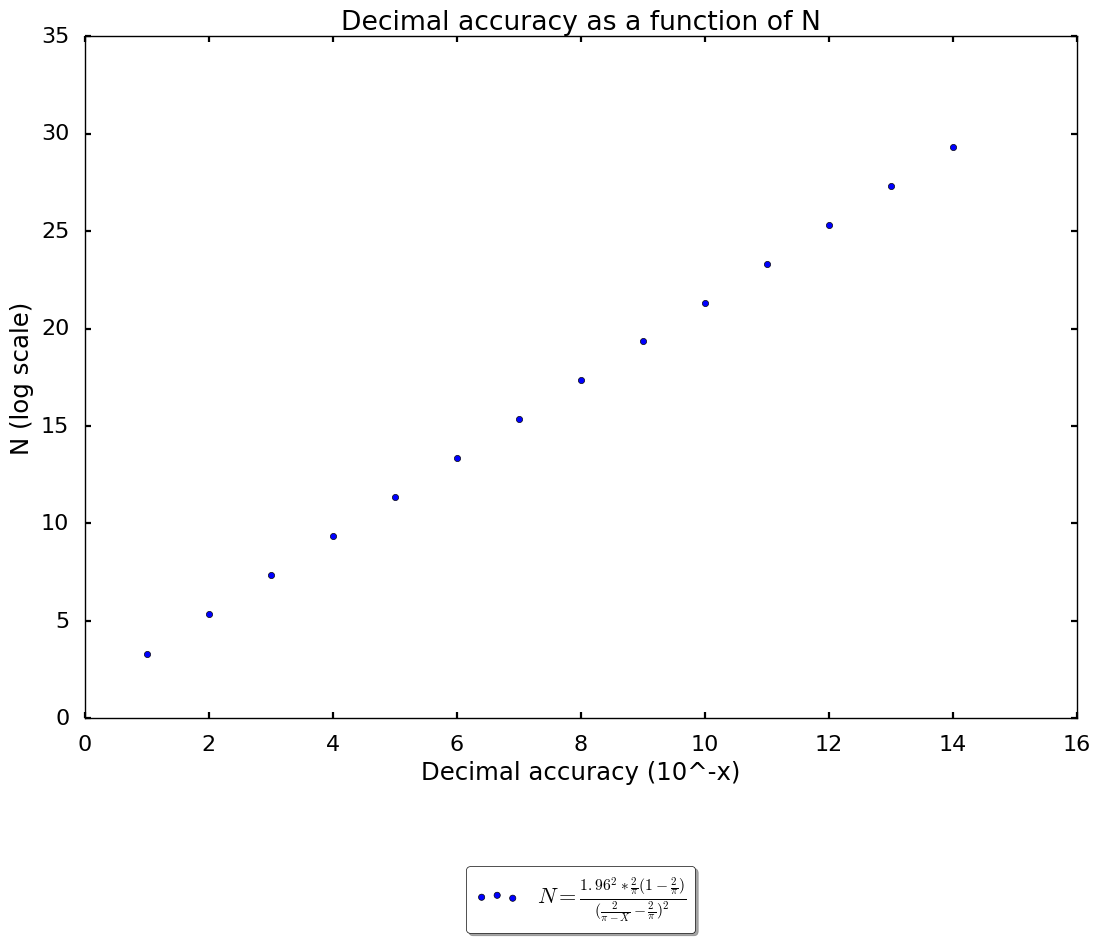

In [118]:
'''Plot accuracy graph'''

x_axis = [i for i in range(1,15)]

plt.scatter (x_axis, [np.log10(j) for j in n_needed],c='b', label =r'$ N= \frac{1.96^2 * \frac{2}{\pi}(1-\frac{2}{\pi})}{(\frac{2}{\pi -X} - \frac{2}{\pi})^2} $')
# plt.scatter (x_axis, [np.log10(10**j) for j in x_axis],c='g', label = r'$N \propto 10^x$')
plt.xlabel ('Decimal accuracy (10^-x)')
plt.ylabel ('N (log scale)')
plt.title ("Decimal accuracy as a function of N")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)
plt.show ()